# PyTorch图像识别示例 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.datasets import CIFAR10
from torchvision import transforms as tfs

import matplotlib.pyplot as plt
import numpy as np

## Step1-cifar10数据集

In [2]:
# torchvision输出的是PILImage，值的范围是[0, 1].
# 我们将其转化为tensor数据，并归一化为[-1, 1]。
transform=transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])

# 训练集，将相对目录./data下的cifar-10-batches-py文件夹中的全部数据（50000张图片作为训练数据）加载到内存中
trainset = torchvision.datasets.CIFAR10(root='./../../dataset', train=True, download=False, transform=transform)

# 将训练集的50000张图片划分成12500份，每份4张图，用于mini-batch输入。shffule=True在表示不同批次的数据遍历时，打乱顺序。
# num_workers=2表示使用两个子进程来加载数据
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print len(trainset)
print len(trainloader)

50000
12500


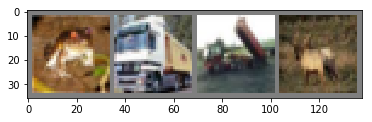

 frog truck truck  deer


Process Process-2:
Process Process-1:
Traceback (most recent call last):
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/Library/Python/2.7/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
  File "/Library/Python/2.7/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
    r = index_queue.get()
  Fi

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# show some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

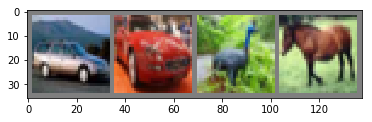

  car   car  bird horse


In [4]:
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

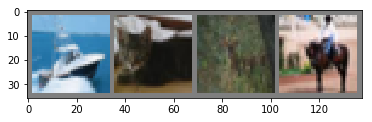

 ship   cat  deer horse


In [5]:
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

## Step2-cifar10使用数据增强

In [6]:
from utils import train, resnet
from torchvision import transforms as tfs

In [7]:
# 使用数据增强
def train_tf(x):
    im_aug = tfs.Compose([
        tfs.Resize(120),
        tfs.RandomHorizontalFlip(),
        tfs.RandomCrop(96),
        tfs.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = im_aug(x)
    return x

def test_tf(x):
    im_aug = tfs.Compose([
        tfs.Resize(96),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = im_aug(x)
    return x

train_set = CIFAR10('./../../dataset', train=True, transform=train_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_set = CIFAR10('./../../dataset', train=False, transform=test_tf)
test_data = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

### 定义残差模块

In [8]:
def conv3x3(in_channel, out_channel, stride=1):
    return nn.Conv2d(
        in_channel, out_channel, 3, stride=stride, padding=1, bias=False)

class residual_block(nn.Module):
    def __init__(self, in_channel, out_channel, same_shape=True):
        super(residual_block, self).__init__()
        self.same_shape = same_shape
        stride = 1 if self.same_shape else 2

        self.conv1 = conv3x3(in_channel, out_channel, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channel)

        self.conv2 = conv3x3(out_channel, out_channel)
        self.bn2 = nn.BatchNorm2d(out_channel)
        if not self.same_shape:
            self.conv3 = nn.Conv2d(in_channel, out_channel, 1, stride=stride)

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out), True)
        out = self.conv2(out)
        out = F.relu(self.bn2(out), True)

        if not self.same_shape:
            x = self.conv3(x)
        return F.relu(x + out, True)

### 定义参数网络模型

In [9]:
class resnet(nn.Module):
    def __init__(self, in_channel, num_classes, verbose=False):
        super(resnet, self).__init__()
        self.verbose = verbose

        self.block1 = nn.Conv2d(in_channel, 64, 7, 2)

        self.block2 = nn.Sequential(
            nn.MaxPool2d(3, 2), residual_block(64, 64), residual_block(64, 64))

        self.block3 = nn.Sequential(
            residual_block(64, 128, False), residual_block(128, 128))

        self.block4 = nn.Sequential(
            residual_block(128, 256, False), residual_block(256, 256))

        self.block5 = nn.Sequential(
            residual_block(256, 512, False),
            residual_block(512, 512), nn.AvgPool2d(3))

        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.block1(x)
        if self.verbose:
            print('block 1 output: {}'.format(x.shape))
        x = self.block2(x)
        if self.verbose:
            print('block 2 output: {}'.format(x.shape))
        x = self.block3(x)
        if self.verbose:
            print('block 3 output: {}'.format(x.shape))
        x = self.block4(x)
        if self.verbose:
            print('block 4 output: {}'.format(x.shape))
        x = self.block5(x)
        if self.verbose:
            print('block 5 output: {}'.format(x.shape))
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x
    
net = resnet(3, 10)

### 训练网络

In [10]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [11]:
from datetime import datetime

def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().data[0]
    return float(num_correct) / total

def train(net, train_data, valid_data, num_epochs, optimizer, criterion):
    if torch.cuda.is_available():
        net = net.cuda()
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        for im, label in train_data:
            if torch.cuda.is_available():
                im = Variable(im.cuda())  # (bs, 3, h, w)
                label = Variable(label.cuda())  # (bs, h, w)
            else:
                im = Variable(im)
                label = Variable(label)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data[0]
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                if torch.cuda.is_available():
                    im = Variable(im.cuda(), volatile=True)
                    label = Variable(label.cuda(), volatile=True)
                else:
                    im = Variable(im, volatile=True)
                    label = Variable(label, volatile=True)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.data[0]
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

In [12]:
train(net, train_data, test_data, 5, optimizer, criterion)

KeyboardInterrupt: 

## Step3-不使用数据增强

In [ ]:
def data_tf(x):
    im_aug = tfs.Compose([
        tfs.Resize(96),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = im_aug(x)
    return x

train_set = CIFAR10('./../../dataset', train=True, transform=data_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_set = CIFAR10('./../../dataset', train=False, transform=data_tf)
test_data = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

net = resnet(3, 10)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
train(net, train_data, test_data, 5, optimizer, criterion)